# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# !pip install ./python
# !pip install progressbar
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
# for local environment
env = UnityEnvironment(file_name="Tennis.app")

## for udacity workspace
# env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Train Multi-Agent!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import numpy as np
import progressbar as pb
from maddpg_agent import Agent


SOLVED_SCORE = 0.5
PRINT_EVERY = 10
PLOT_EVERY = 100
EPS_DECAY = 0.996
ADD_NOISE = True

ACTOR_LOSS = []
CRITIC_LOSS = []
SCORES_WINDOW = deque(maxlen=100)
SCORE_ALL = []
MOVING_AVERAGE = []
BEST_SCORE = -np.inf
BEST_EPISODE = 0

agent = Agent(state_size, action_size, num_agents, random_seed=0)

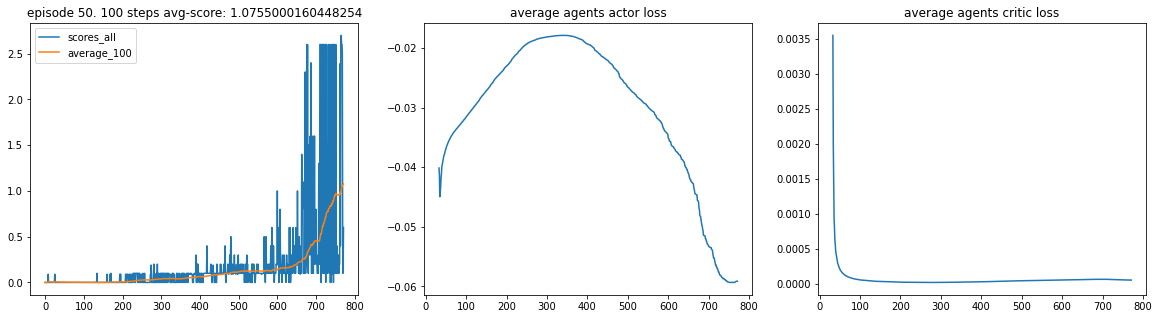

Episodes 0040-0050	Max Reward: 2.700	Moving Average: 247.000	 Step Num:1.0755000160448254


In [13]:
N_EPISODES = 50  # if restart train recommand set 1000
BATCH_SIZE = 512
PRINT_EVERY = 10
already_solved = True  # if restart train set False

for i_episode in range(1, N_EPISODES + 1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    steps = 0
    # agent.reset(EPS_DECAY)
    while True:  # 1 episde for test
        actions = agent.act(states, ADD_NOISE)
        env_info = env.step(actions)[brain_name]  # send both agents' actions to the environment
        # next_states = np.reshape(env_info.vector_observations, (1, num_agents*state_size)) # flatten next states
        next_states = env_info.vector_observations
        rewards = env_info.rewards  # get rewards
        done = env_info.local_done  # see if the episode finished

        # perform the trainning step
        agent.step(states, actions, rewards, next_states, done)

        scores += rewards  # update scores with best reward
        steps += 1
        states = next_states  # roll over states to next time step
        if np.any(done):  # exit loop if episode finished
            break

    ep_max_score = np.max(scores)
    SCORES_WINDOW.append(ep_max_score)
    SCORE_ALL.append(ep_max_score)
    MOVING_AVERAGE.append(np.mean(SCORES_WINDOW))
    ACTOR_LOSS.append(np.mean(agent.actor_loss_list))
    CRITIC_LOSS.append(np.mean(agent.critic_loss_list))

    if i_episode % PLOT_EVERY == 0:
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('episode %s. 100 steps avg-score: %s' % (i_episode, MOVING_AVERAGE[-1]))
        plt.plot(SCORE_ALL, label='scores_all')
        plt.plot(MOVING_AVERAGE, label='average_100')
        plt.legend()
        plt.subplot(132)
        plt.title('average agents actor loss')
        plt.plot(ACTOR_LOSS)
        plt.subplot(133)
        plt.title('average agents critic loss')
        plt.plot(CRITIC_LOSS)
        plt.show()

    print('\rEpi-Steps {}/{} \tReward: {}\tActor Loss:{:.6f}\t Critic Loss:{:.6f}\t EPS:{:.4f}'.format(
        i_episode, steps, scores, np.mean(agent.actor_loss_list), np.mean(agent.critic_loss_list), agent.eps), end='')

    # print results
    if i_episode % PRINT_EVERY == 0:
        print('\rEpisodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}\t Step Num:{}'
              .format(i_episode - PRINT_EVERY, i_episode, np.max(SCORE_ALL[-PRINT_EVERY:]), MOVING_AVERAGE[-1], steps))
            
    # save better model
    if ep_max_score > BEST_SCORE and len(agent.memory) >= BATCH_SIZE:
        BEST_EPISODE = i_episode
        BEST_SCORE = ep_max_score
        print('\r<-- Best episode so far! \nEpisode {:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}\t Step Num:{}'
              .format(i_episode, BEST_SCORE, MOVING_AVERAGE[-1], steps))
        agent.save_model()

    # determine if environment is solved and save best performing models
    if MOVING_AVERAGE[-1] >= SOLVED_SCORE and len(agent.memory) >= BATCH_SIZE:
        if not already_solved:
            print('\r<-- Environment solved in {:d} episodes! \
                \n<-- Moving Average: {:.3f} over past {:d} episodes'.format(
                i_episode - 100, MOVING_AVERAGE[-1], 100))
            already_solved = True
            agent.save_model()
            break

### 4. Take Random Actions in the Environment
Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

### 5. Take Trained Actions in the Environment
Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [15]:
import torch
new_agent = Agent(state_size, action_size, num_agents, random_seed=0)
actor0 = torch.load('assets/checkpoint_actor_0.pth', map_location='cpu')
actor1 = torch.load('assets/checkpoint_actor_1.pth', map_location='cpu')
agent.actors_local[0].load_state_dict(actor0)
agent.actors_local[1].load_state_dict(actor1)

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
steps = 0
while True:
    actions = agent.act(states, False)                 # select an action (for each agent)
    # actions = np.clip(actions, -1, 1)                # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    steps += 1
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Max score (One agents) this episodes: {}'.format(np.max(scores)))
print('Total steps num: {}'.format(steps))

Max score (One agents) this episodes: 2.600000038743019
Total steps num: 1001


When finished, you can close the environment.

In [ ]:
env.close()